# 1- Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import string
import re
import os
import nltk
from nltk.corpus import stopwords, twitter_samples
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt 

# 2- Loading and Preprocessing data

In [2]:
imdb_data_path = "../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"

In [3]:
imdb_data = pd.read_csv(imdb_data_path)

In [4]:
# Converting the positive labels to 1 and the negative labels to 0

imdb_data['sentiment'].mask(imdb_data['sentiment'] == 'positive', 1, inplace=True)
imdb_data['sentiment'].mask(imdb_data['sentiment'] == 'negative', 0, inplace=True)

In [5]:
# Get the reviews and the labels

all_reviews = list(imdb_data['review'])
labels = np.asarray(imdb_data['sentiment'])

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# cutoff reviews after 200 words
maxlen = 200
training_samples = 40000
validation_samples = 5000
testing_samples = 5000

# consider the top 100000 words in the dataset
max_words = 100000

# tokenize each review in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(all_reviews)
sequences = tokenizer.texts_to_sequences(all_reviews)

In [7]:
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))
ind2word = dict([(value, key) for (key, value) in word_index.items()])

Found 124252 unique tokens.


In [9]:
# pad the sequences so that all sequences are of the same size
data = pad_sequences(sequences, maxlen=maxlen)

In [10]:
# shuffling the data and labels

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

# Splitting the data set to training and validation datasets 

x_train = data[: training_samples]
y_train = labels[: training_samples]

x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

x_test = data[training_samples + validation_samples: training_samples + validation_samples + testing_samples]
y_test = labels[training_samples + validation_samples: training_samples + validation_samples + testing_samples]

x_train = np.asarray(x_train).astype(np.int)
y_train = np.asarray(y_train).astype(np.int)
x_val = np.asarray(x_val).astype(np.int)
y_val = np.asarray(y_val).astype(np.int)
x_test = np.asarray(x_test).astype(np.int)
y_test = np.asarray(y_test).astype(np.int)

In [11]:
x_train.shape

(40000, 200)

In [12]:
x_val.shape

(5000, 200)

In [13]:
x_test.shape

(5000, 200)

# 3- Deep Learning Models

## 3.1- Simple Model 

In [14]:
embedding_dim = 300
simple_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

simple_model.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

simple_model_history = simple_model.fit(x_train,y_train,
                                        validation_data=(x_val,y_val),
                                        epochs=5)

Epoch 1/5
1250/1250 [==============================] - 14s 10ms/step - loss: 0.3234 - accuracy: 0.8572 - val_loss: 0.2661 - val_accuracy: 0.8856
Epoch 2/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.1568 - accuracy: 0.9402 - val_loss: 0.3017 - val_accuracy: 0.8846
Epoch 3/5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0879 - accuracy: 0.9645 - val_loss: 0.3898 - val_accuracy: 0.8750
Epoch 4/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0548 - accuracy: 0.9779 - val_loss: 0.5235 - val_accuracy: 0.8682
Epoch 5/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0349 - accuracy: 0.9869 - val_loss: 0.6521 - val_accuracy: 0.8740


# 4- Models Performance visualization

In [15]:
def plot_acc_and_loss(model_histpry):

    acc = model_histpry.history['accuracy']
    val_acc = model_histpry.history['val_accuracy']

    loss = model_histpry.history['loss']
    val_loss = model_histpry.history['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 4), dpi=80)

    ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
    ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
    ax[0].grid(alpha=0.3)
    ax[0].title.set_text('Training Vs Validation Accuracy')
    ax[0].fill_between(epochs, acc, val_acc, color='crimson', alpha=0.3)
    plt.setp(ax[0], xlabel='Epochs')
    plt.setp(ax[0], ylabel='Accuracy')


    ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
    ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
    ax[1].grid(alpha=0.3)
    ax[1].title.set_text('Training Vs Validation Loss')
    ax[1].fill_between(epochs,loss, val_loss, color='crimson', alpha=0.3)
    plt.setp(ax[1], xlabel='Epochs')
    plt.setp(ax[1], ylabel='Loss')

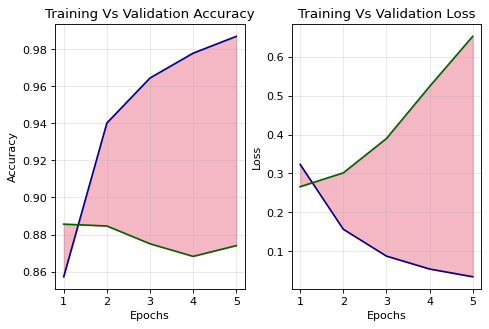

In [16]:
plot_acc_and_loss(simple_model_history)

# 5- Testing and Prediction

In [17]:
def eval_model(model):
    
    model_acc_train_dataset = model.evaluate(x_train, y_train)
    model_acc_val_dataset = model.evaluate(x_val, y_val)
    model_acc_test_dataset = model.evaluate(x_test, y_test)
    
    return model_acc_train_dataset, model_acc_val_dataset, model_acc_test_dataset

simple_model_acc_train_dataset, simple_model_acc_val_dataset, simple_model_acc_test_dataset = eval_model(simple_model)
#simple_rnn_model_acc_train_dataset, simple_rnn_model_acc_val_dataset, simple_rnn_model_acc_test_dataset = eval_model(simple_rnn_model)


train_accs = [simple_model_acc_train_dataset[1]]

val_accs = [simple_model_acc_val_dataset[1]]

test_accs = [simple_model_acc_test_dataset[1]]

models_eval_df = pd.DataFrame({"Training Accuracy":train_accs, "Validation Accuracy":val_accs, "Testing Accuracy":test_accs},
                              index=['simple_model'])

157/157 [==============================] - 0s 2ms/step - loss: 0.6533 - accuracy: 0.8676


In [18]:
models_eval_df

Training Accuracy  Validation Accuracy  Testing Accuracy
simple_model           0.993225                0.874            0.8676

In [21]:
class_names = ["Positive","Negative"]

In [20]:
y_predict=simple_model.predict(y_test)

In [31]:
y_predict=y_predict.astype(int)

In [32]:
 from sklearn.metrics import classification_report, confusion_matrix

In [33]:
print(classification_report(y_test, y_predict, target_names=class_names))

print(confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

    Positive       0.50      1.00      0.67      2523
    Negative       0.00      0.00      0.00      2477

    accuracy                           0.50      5000
   macro avg       0.25      0.50      0.34      5000
weighted avg       0.25      0.50      0.34      5000

[[2523    0]
 [2477    0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
